# 📌 1. Importación de librerías y funciones útiles

In [104]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    BatchNormalization,
    GlobalAveragePooling2D,
    Concatenate,
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 📊 Función de evaluación completa para modelos de clasificación
def evaluate_model(y_true, y_pred_probs, label_encoder, model_name="Modelo"):
    """
    Muestra la matriz de confusión, accuracy y el classification report.

    Parámetros:
    -----------
    y_true : array-like
        Etiquetas verdaderas (pueden ser one-hot o enteros)

    y_pred_probs : array-like
        Probabilidades de predicción (salida de model.predict)

    label_encoder : LabelEncoder
        Codificador usado para transformar las clases originales

    model_name : str
        Título que aparecerá en los gráficos y reportes
    """

    # 🔢 Asegurar que las etiquetas estén en formato entero
    if len(y_true.shape) > 1:
        y_true_labels = np.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true

    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # ✅ Precisión global
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    print(f"\n✅ Precisión total de {model_name}: {accuracy:.4f}")

    # 📋 Reporte detallado
    print(f"\n📊 Classification Report ({model_name}):")
    print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

    # 🔷 Matriz de confusión
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

    # 📉 Visualización
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.tight_layout()
    plt.show()

    return accuracy

In [3]:
import matplotlib.pyplot as plt

# 📈 Función para visualizar las curvas de pérdida y precisión
def plot_training_curves(history, model_name="Modelo"):
    """
    Muestra las curvas de pérdida y precisión del entrenamiento.

    Parámetros:
    -----------
    history : keras.callbacks.History
        Objeto retornado por model.fit()
    
    model_name : str
        Nombre del modelo para personalizar el título
    """
    # 🔹 Curva de pérdida
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title(f'Pérdida (Loss) - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 🔸 Curva de precisión
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title(f'Precisión (Accuracy) - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
def predict_and_show_image(image_id, model, label_encoder, metadata, image_array, img_size=96):
    """
    Muestra una imagen individual con la predicción de clase realizada por un modelo entrenado.

    Parámetros:
    -----------
    image_id : int
        Índice de la imagen a predecir (correspondiente a la posición en metadata/images)

    model : keras.Model
        Modelo entrenado para realizar la predicción

    label_encoder : LabelEncoder
        LabelEncoder usado para decodificar las etiquetas predichas

    metadata : DataFrame
        DataFrame original con la información de cada imagen

    image_array : np.ndarray
        Array de imágenes preprocesadas (formato (N, H, W, 3))

    img_size : int
        Tamaño al que se redimensionan las imágenes (default = 96)
    """

    # 📋 Extraer datos asociados a la imagen
    data_info = metadata.iloc[image_id]
    image = image_array[image_id]

    print("📄 Metadata asociada:")
    print(data_info)
    print("\n📐 Shape original de la imagen:", image.shape)

    # 🔄 Redimensionar imagen como durante el entrenamiento
    resized_img = tf.image.resize(image, (img_size, img_size))
    resized_img = np.expand_dims(resized_img, axis=0)  # → (1, img_size, img_size, 3)

    # 🔍 Realizar predicción
    prediction = model.predict(resized_img)
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # 🖼️ Visualizar imagen con predicción
    plt.imshow(image)
    plt.title(f"🔎 Predicción: {predicted_label}", fontsize=14)
    plt.axis("off")
    plt.show()

    return predicted_label

In [5]:
def predict_new_patient(model, patient_info, scaler, le_sex, le_loc, le_dx):
    """
    Predice el diagnóstico de un nuevo paciente usando un modelo tabular entrenado.

    Parámetros:
    -----------
    model : keras.Model
        Modelo entrenado para datos tabulares

    patient_info : dict
        Diccionario con la información del paciente (debe incluir 'age', 'sex' y 'localization')

    scaler : StandardScaler
        Escalador ajustado con los datos de entrenamiento

    le_sex : LabelEncoder
        Codificador de la columna 'sex'

    le_loc : LabelEncoder
        Codificador de la columna 'localization'

    le_dx : LabelEncoder
        Codificador de la variable objetivo (dx)

    Retorna:
    --------
    str : Clase predicha (nombre del diagnóstico)
    """

    # 📦 Extraer y codificar valores
    age = patient_info["age"]
    sex_code = le_sex.transform([patient_info["sex"]])[0]
    loc_code = le_loc.transform([patient_info["localization"]])[0]

    # 🧾 Crear array con los datos codificados
    X_input = np.array([[age, sex_code, loc_code]])

    # 🔄 Escalar con el mismo scaler que se usó para entrenamiento
    X_scaled = scaler.transform(X_input)

    # 🤖 Realizar predicción
    prediction_probs = model.predict(X_scaled)
    prediction_class = np.argmax(prediction_probs)
    predicted_label = le_dx.inverse_transform([prediction_class])[0]

    # 🩺 Mostrar diagnóstico
    print(f"📋 Diagnóstico predicho: {predicted_label}")

    return predicted_label

In [86]:
# 🔁 Función para predecir a partir de una imagen y datos de paciente
def predict_combined_case(
    image_id, metadata, images_array, patient_info,
    model, le_sex, le_loc, le_dx, scaler, img_size=96
):
    """
    Realiza una predicción usando el modelo combinado de imagen + datos tabulares.

    Parámetros:
    -----------
    image_id : int
        Índice de la imagen (correspondiente al metadata / images_array)

    metadata : DataFrame
        DataFrame original con información del paciente

    images_array : np.ndarray
        Array de imágenes (formato (N, H, W, 3))

    patient_info : dict
        Diccionario con datos del paciente (age, sex, localization)

    model : keras.Model
        Modelo entrenado con entrada combinada (imagen + tabular)

    le_sex, le_loc, le_dx : LabelEncoder
        Codificadores entrenados para sex, localization y diagnóstico (dx)

    scaler : StandardScaler
        Escalador ajustado con los datos tabulares

    img_size : int
        Tamaño al que se redimensiona la imagen (por defecto 96)

    Retorna:
    --------
    str : Clase predicha (nombre del diagnóstico)
    """

    # 📋 Obtener datos de la imagen y su metadata
    img = images_array[image_id]
    print("📄 Metadata del caso:")
    print(metadata.iloc[image_id])
    print("📐 Shape de la imagen original:", img.shape)

    # 🔄 Redimensionar imagen
    img_resized = tf.image.resize(img, (img_size, img_size))
    img_resized = np.expand_dims(img_resized, axis=0)  # (1, img_size, img_size, 3)

    # 📊 Codificar datos tabulares del nuevo paciente
    age = patient_info["age"]
    sex_code = le_sex.transform([patient_info["sex"]])[0]
    loc_code = le_loc.transform([patient_info["localization"]])[0]
    X_tabular = np.array([[age, sex_code, loc_code]])
    X_tabular_scaled = scaler.transform(X_tabular)

    # 🔮 Realizar predicción
    pred = model.predict([img_resized, X_tabular_scaled])
    predicted_class = np.argmax(pred)
    class_name = le_dx.inverse_transform([predicted_class])[0]

    # 🖼️ Mostrar imagen con resultado
    plt.imshow(img)
    plt.title(f"Predicción: {class_name}")
    plt.axis("off")
    plt.show()

    print(f"✅ Diagnóstico predicho: {class_name}")
    return class_name


# 📂 2. Carga y preparación de datos

In [6]:
# Cargamos el dataset de imágenes y metadatos
metadata = pd.read_csv("HAM10000_metadata.csv")
images = np.loadtxt('hnmist_28_28_RGB.csv', delimiter=',', skiprows=1)
num_images = images.shape[0]
images = images.reshape((num_images, 28, 28, 3))
images = images / 255.0

In [7]:
print("Imágenes:", images.shape)
print("Etiquetas:", metadata.shape)

Imágenes: (10015, 28, 28, 3)
Etiquetas: (10015, 7)


In [8]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
# 📊 Ver porcentaje de representación de cada clase en el dataset
class_percentages = metadata['dx'].value_counts(normalize=True) * 100

# 🔍 Mostrar los porcentajes redondeados al 2º decimal
print(class_percentages.round(2))

dx
nv       66.95
mel      11.11
bkl      10.97
bcc       5.13
akiec     3.27
vasc      1.42
df        1.15
Name: proportion, dtype: float64


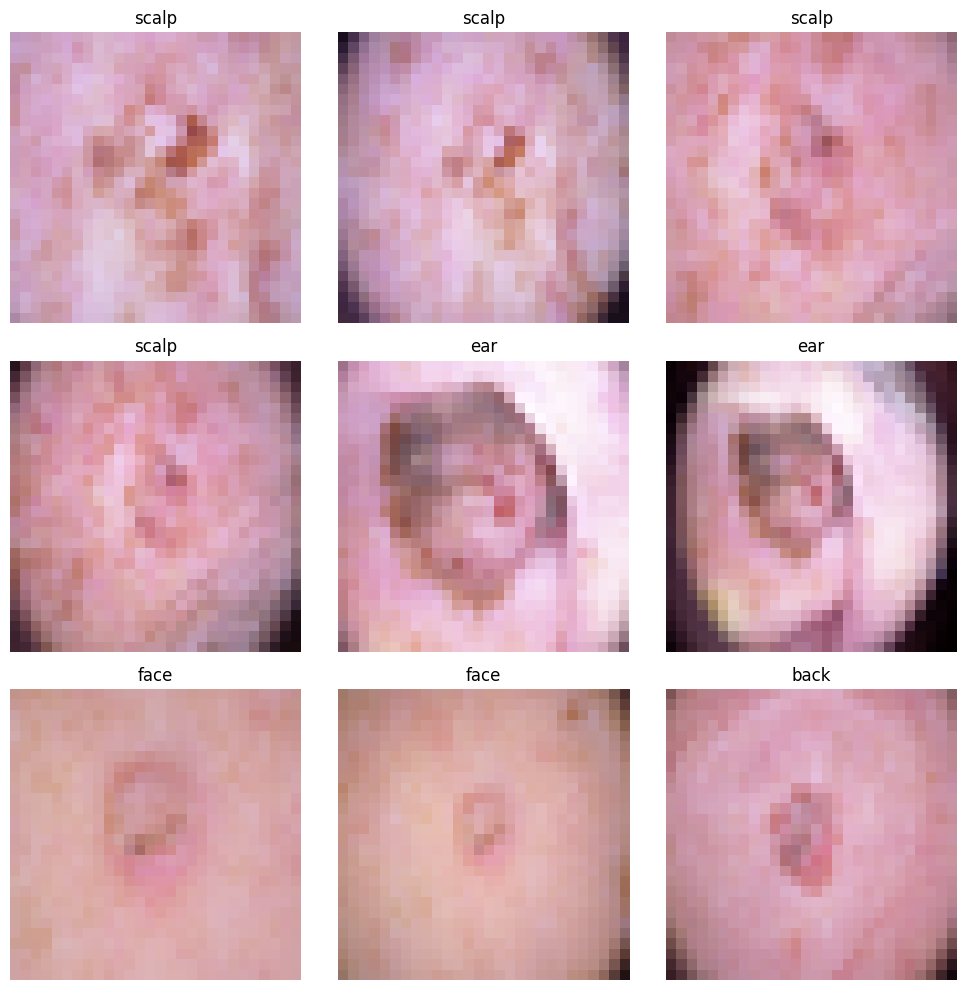

In [10]:
# 🖼️ Visualizar un conjunto de imágenes del dataset con su localización anatómica
num_images_to_show = 9

plt.figure(figsize=(10, 10))

for i in range(num_images_to_show):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    # Obtener localización anatómica de la imagen actual
    location = metadata.iloc[i]['localization']
    plt.title(f"{location}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Cantidad disponible para 'bkl': 1099


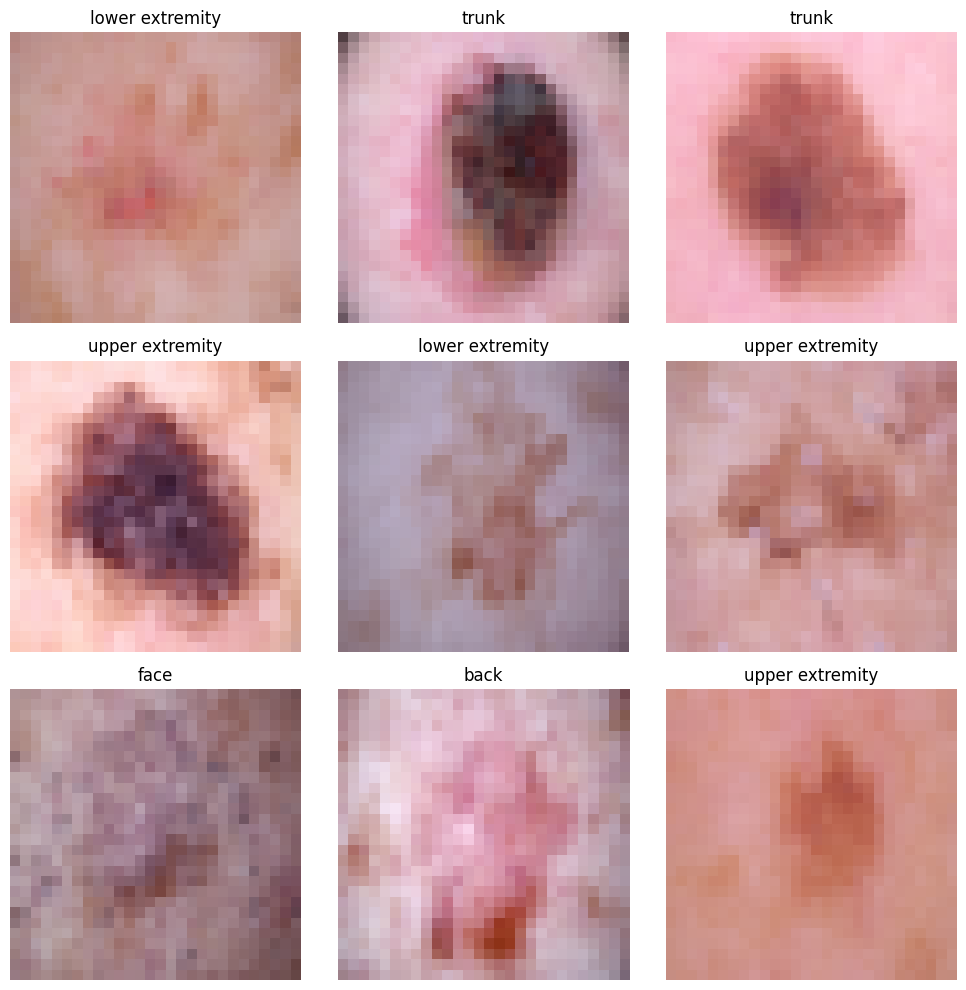

In [11]:
import random

# 🧐 Visualizar imágenes de una clase específica (ej: 'bkl')
target_class = 'bkl'

# Filtrar el DataFrame por la clase deseada
filtered_subset = metadata[metadata['dx'] == target_class]
filtered_indices = filtered_subset.index.tolist()

# Mostrar cuántas imágenes hay de esa clase
print(f"Cantidad disponible para '{target_class}':", len(filtered_indices))

# Determinar cuántas imágenes mostrar (máx 9)
num_to_show = min(9, len(filtered_indices))
sample_indices = random.sample(filtered_indices, num_to_show)

# Visualización
plt.figure(figsize=(10, 10))
for i in range(num_to_show):
    idx = sample_indices[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx])
    
    # Mostrar localización anatómica como título
    location = metadata.iloc[idx]['localization']
    plt.title(f"{location}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# 🧪 3. División en train/val/test

In [12]:
# 🔠 Conversión de etiquetas numéricas a codificación one-hot
# Esto es necesario para clasificación multiclase con softmax

# Codificar las etiquetas (de texto a enteros)
le_dx = LabelEncoder()
y_encoded = le_dx.fit_transform(metadata['dx'])

# Convertir a one-hot
y_cat = to_categorical(y_encoded)

In [112]:
# 🔹 Dividir datos primero para evitar data leakage
total_indices = np.arange(num_images)
train_idx, temp_idx, y_train_raw, y_temp_raw = train_test_split(
    total_indices, y_cat, test_size=0.3, random_state=42, stratify=y_cat
)
val_idx, test_idx, y_val_raw, y_test_raw = train_test_split(
    temp_idx, y_cat[temp_idx], test_size=0.5, random_state=42, stratify=y_cat[temp_idx]
)

# 📋 Selección de columnas relevantes (antes de dividir)
df_tabular = metadata[["age", "sex", "localization", "dx"]].copy()

# División en train/val/test
df_train = df_tabular.iloc[train_idx].copy()
df_val = df_tabular.iloc[val_idx].copy()
df_test = df_tabular.iloc[test_idx].copy()

# División de imágenes y etiquetas
X_img_train = images[train_idx]
X_img_val = images[val_idx]
X_img_test = images[test_idx]

y_train = y_cat[train_idx]
y_val = y_cat[val_idx]
y_test = y_cat[test_idx]

print("Tamaño de train:", df_train.shape)
print("Tamaño de val:", df_val.shape)
print("Tamaño de test:", df_test.shape)
print("\t")
print("Tamaño de imágenes train:", X_img_train.shape)
print("Tamaño de imágenes val:", X_img_val.shape)
print("Tamaño de imágenes test:", X_img_test.shape)
print("\t")
print("Tamaño de etiquetas train:", y_train.shape)
print("Tamaño de etiquetas val:", y_val.shape)
print("Tamaño de etiquetas test:", y_test.shape)

Tamaño de train: (7010, 4)
Tamaño de val: (1502, 4)
Tamaño de test: (1503, 4)
	
Tamaño de imágenes train: (7010, 28, 28, 3)
Tamaño de imágenes val: (1502, 28, 28, 3)
Tamaño de imágenes test: (1503, 28, 28, 3)
	
Tamaño de etiquetas train: (7010, 7)
Tamaño de etiquetas val: (1502, 7)
Tamaño de etiquetas test: (1503, 7)


In [14]:
# 🔢 Obtener el número de clases a partir del shape del vector one-hot
num_classes = y_train.shape[1]
print(f"num_classes: {num_classes}")

num_classes: 7


# 🔢 4. Preprocesado de datos tabulares

In [15]:
# 🧼 Imputación de edad SOLO con media del train
age_mean = df_train['age'].mean()

df_train['age'] = df_train['age'].fillna(age_mean)
df_val['age']   = df_val['age'].fillna(age_mean)
df_test['age']  = df_test['age'].fillna(age_mean)

In [16]:
# 🔠 Codificación de variables categóricas con LabelEncoder
le_sex = LabelEncoder()
le_loc = LabelEncoder()
le_dx = LabelEncoder()

# Aplica el fit solo sobre el conjunto de entrenamiento
df_train['sex'] = le_sex.fit_transform(df_train['sex'].fillna('unknown'))
df_train['localization'] = le_loc.fit_transform(df_train['localization'].fillna('unknown'))

# Aplica el transform sobre val y test
df_val['sex'] = le_sex.transform(df_val['sex'].fillna('unknown'))
df_val['localization'] = le_loc.transform(df_val['localization'].fillna('unknown'))
df_test['sex'] = le_sex.transform(df_test['sex'].fillna('unknown'))
df_test['localization'] = le_loc.transform(df_test['localization'].fillna('unknown'))

# Codificar clase (dx) como variable objetivo
df_train['dx'] = le_dx.fit_transform(df_train['dx'])
df_val['dx'] = le_dx.fit_transform(df_val['dx'])
df_test['dx'] = le_dx.fit_transform(df_test['dx'])

In [17]:
X_train_raw = df_train[['age', 'sex', 'localization']].values
X_val_raw = df_val[['age', 'sex', 'localization']].values
X_test_raw = df_test[['age', 'sex', 'localization']].values

In [18]:
# Normalizar solo con entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

# 🧠 5. Modelo tabular (Hito 1)
# Red neuronal densa optimizada con Hyperopt

In [19]:
# 🎯 Función objetivo para optimización con Hyperopt
def objective(params):
    # Extraer hiperparámetros
    learning_rate = params['learning_rate']
    batch_size = int(params['batch_size'])
    units1 = int(params['units1'])
    units2 = int(params['units2'])

    # 🔧 Definir modelo secuencial simple para datos tabulares
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(units2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compilar el modelo con optimizador Adam
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenamiento del modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,  # 🔁 Puedes aumentarlo para producción
        batch_size=batch_size,
        verbose=0
    )

    # Usar precisión de validación como métrica a maximizar
    val_acc = history.history['val_accuracy'][-1]

    return {'loss': -val_acc, 'status': STATUS_OK}


In [20]:
# 🔎 Espacio de búsqueda de hiperparámetros
search_space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-4), np.log(1e-2)),
    "batch_size": hp.choice("batch_size", [16, 32, 64]),
    "units1": hp.choice("units1", [32, 64, 128]),
    "units2": hp.choice("units2", [16, 32, 64]),
}

# 🚀 Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best_params = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=20, trials=trials
)

print("\n✅ Mejor combinación encontrada:")
print(best_params)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 20/20 [01:20<00:00,  4.03s/trial, best loss: -0.6930758953094482]

✅ Mejor combinación encontrada:
{'batch_size': np.int64(1), 'learning_rate': np.float64(0.0032384680068389604), 'units1': np.int64(0), 'units2': np.int64(2)}


In [21]:
batch_sizes = [16, 32, 64]
units1_list = [32, 64, 128]
units2_list = [16, 32, 64]

print("\nMejor combinación encontrada (decodificada):")
print(f"batch_size: {batch_sizes[best_params['batch_size']]}")
print(f"learning_rate: {best_params['learning_rate']:.6f}")
print(f"units1: {units1_list[best_params['units1']]}")
print(f"units2: {units2_list[best_params['units2']]}")


Mejor combinación encontrada (decodificada):
batch_size: 32
learning_rate: 0.003238
units1: 32
units2: 64


In [22]:
# 📊 Cálculo de pesos de clase para lidiar con desbalanceo
# 🎯 Paso 1: Convertir etiquetas one-hot a enteros
y_train_labels = np.argmax(y_train, axis=1)

# ⚖️ Paso 2: Calcular pesos de clase equilibrados automáticamente
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels
)

# 📦 Paso 3: Convertir el array a diccionario para usarlo en model.fit()
class_weights_dict = dict(enumerate(class_weights))

# 🔍 Visualizar los pesos calculados
print("\n📌 Pesos de clase calculados:")
print(class_weights_dict)


📌 Pesos de clase calculados:
{0: np.float64(4.37305053025577), 1: np.float64(2.7817460317460316), 2: np.float64(1.3022478172023035), 3: np.float64(12.36331569664903), 4: np.float64(1.285530900421786), 5: np.float64(0.21338772031292808), 6: np.float64(10.115440115440116)}


In [23]:
# 🧠 Entrenamiento final del modelo tabular con los mejores hiperparámetros

# 🔧 Definición de la arquitectura del modelo MLP para datos tabulares
input_tab = Input(shape=(X_train.shape[1],), name="tabular_input")
x = Dense(units1_list[best_params["units1"]], activation="relu")(input_tab)
x = Dropout(0.3)(x)
x = Dense(units2_list[best_params["units2"]], activation="relu")(x)
output = Dense(num_classes, activation="softmax")(x)

# 🧩 Construcción del modelo
model_tab = Model(inputs=input_tab, outputs=output)

# ⚙️ Compilación con los mejores hiperparámetros encontrados por Hyperopt
model_tab.compile(
    optimizer=Adam(learning_rate=best_params["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [24]:
model_tab.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tabular_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,695 (10.53 KB)

 Trainable params: 2,695 (10.53 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# 🛑 Parada temprana para evitar sobreentrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# 🚀 Entrenamiento del modelo usando los pesos de clase
history_tab_w = model_tab.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=batch_sizes[best_params["batch_size"]],
    shuffle=True,
    class_weight=class_weights_dict,
    # callbacks=[early_stop],
)

Epoch 1/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3236 - loss: 1.9050 - val_accuracy: 0.0772 - val_loss: 1.8117
Epoch 2/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2684 - loss: 1.8247 - val_accuracy: 0.4201 - val_loss: 1.5910
Epoch 3/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2985 - loss: 1.7976 - val_accuracy: 0.1811 - val_loss: 1.7674
Epoch 4/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2857 - loss: 1.7378 - val_accuracy: 0.1778 - val_loss: 1.7310
Epoch 5/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2930 - loss: 1.7022 - val_accuracy: 0.2204 - val_loss: 1.7178
Epoch 6/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2881 - loss: 1.6964 - val_accuracy: 0.2770 - val_loss: 1.7053
Epoch 7/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2511 - loss: 1.7835 - val_accuracy: 0.3562 - val_loss: 1.6429
Epoch 8/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3337 - loss: 1.7342 - val_accuracy: 0.

# 📈 6. Evaluación del modelo tabular

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

✅ Precisión total de Modelo Tabular: 0.3147

📊 Classification Report (Modelo Tabular):
              precision    recall  f1-score   support

       akiec       0.12      0.49      0.20        49
         bcc       0.20      0.48      0.28        77
         bkl       0.21      0.05      0.09       165
          df       0.03      0.53      0.06        17
         mel       0.24      0.18      0.20       167
          nv       0.88      0.36      0.51      1006
        vasc       0.02      0.27      0.04        22

    accuracy                           0.31      1503
   macro avg       0.24      0.34      0.20      1503
weighted avg       0.65      0.31      0.39      1503



<Figure size 800x600 with 0 Axes>

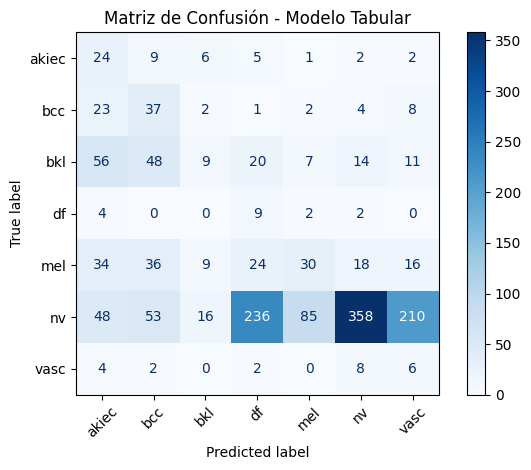

0.3147039254823686

In [26]:
y_pred_probs = model_tab.predict(X_test)
evaluate_model(y_test, y_pred_probs, le_dx, model_name="Modelo Tabular")

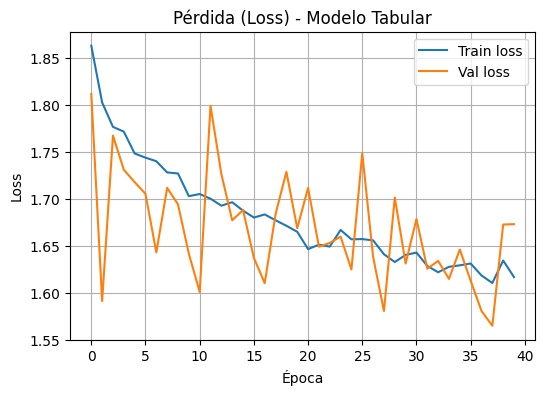

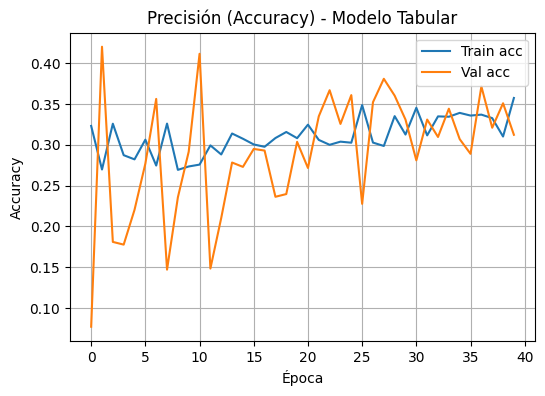

In [27]:
plot_training_curves(history_tab_w, model_name="Modelo Tabular")

In [28]:
new_patient = {"age": 70, "sex": "male", "localization": "ear"}

predict_new_patient(
    model=model_tab,
    patient_info=new_patient,
    scaler=scaler,
    le_sex=le_sex,
    le_loc=le_loc,
    le_dx=le_dx
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
📋 Diagnóstico predicho: bcc


'bcc'

# 🧱 7. Modelo CNN desde cero (Hito 2)

In [93]:
print("Imágenes:", images.shape)
print("Etiquetas:", y_cat.shape)

Imágenes: (10015, 28, 28, 3)
Etiquetas: (10015, 7)


In [94]:
# 🖼️ Definir entrada de imagen (formato RGB 28x28)
input_img = Input(shape=(28, 28, 3), name="image_input")

# 🔷 Bloque convolucional 1
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 🔷 Bloque convolucional 2
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 🔷 Bloque convolucional 3
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 🔻 Paso a capa densa
x = Flatten()(x)
x = Dropout(0.4)(x)  # Regularización antes de capa densa
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

# 🔚 Capa de salida softmax para clasificación multiclase
output = Dense(y_cat.shape[1], activation="softmax", name="output")(x)

# 🧩 Construcción y compilación del modelo
model_img = Model(inputs=input_img, outputs=output)

model_img.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [96]:
model_img.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,631 (947.78 KB)

 Trainable params: 242,183 (946.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [97]:
# 🔄 Data augmentation: generar imágenes ligeramente modificadas en cada época
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotación aleatoria en grados
    width_shift_range=0.1,  # Desplazamiento horizontal
    height_shift_range=0.1,  # Desplazamiento vertical
    zoom_range=0.1,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal
)

In [98]:
# 🚀 Entrenamiento del modelo CNN desde cero con ImageDataGenerator y EarlyStopping
history_img = model_img.fit(
    # datagen.flow(X_img_train, y_train, batch_size=32),  # Flujo con imágenes aumentadas
    X_img_train,  # Imágenes originales para entrenamiento
    y_train,  # Etiquetas de entrenamiento
    validation_data=(X_img_val, y_val),  # Validación sin augmentación
    epochs=50,  # Número máximo de épocas
    # callbacks=[early_stop],  # Parada temprana si no mejora
    class_weight=class_weights_dict,  # Pesos de clase para desbalanceo
    verbose=1,  # Mostrar progreso por época
)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3306 - loss: 2.5890 - val_accuracy: 0.0313 - val_loss: 5.5081
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4473 - loss: 1.5261 - val_accuracy: 0.3182 - val_loss: 2.4579
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4809 - loss: 1.3834 - val_accuracy: 0.4541 - val_loss: 1.4113
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5018 - loss: 1.3466 - val_accuracy: 0.6032 - val_loss: 1.0512
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5471 - loss: 1.2197 - val_accuracy: 0.5426 - val_loss: 1.0183
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5837 - loss: 1.1479 - val_accuracy: 0.4554 - val_loss: 1.4511
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5614 - loss: 1.1143 - val_accuracy: 0.6079 - val_loss: 0.8979
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5649 - loss: 1.0918 - val_accu

# 📈 8. Evaluación del modelo CNN desde 0

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

✅ Precisión total de Modelo CNN desde 0: 0.6846

📊 Classification Report (Modelo CNN desde 0):
              precision    recall  f1-score   support

       akiec       0.50      0.49      0.49        49
         bcc       0.45      0.69      0.55        77
         bkl       0.47      0.53      0.50       165
          df       0.50      0.53      0.51        17
         mel       0.30      0.56      0.39       167
          nv       0.94      0.74      0.83      1006
        vasc       0.53      0.82      0.64        22

    accuracy                           0.68      1503
   macro avg       0.53      0.62      0.56      1503
weighted avg       0.77      0.68      0.71      1503



<Figure size 800x600 with 0 Axes>

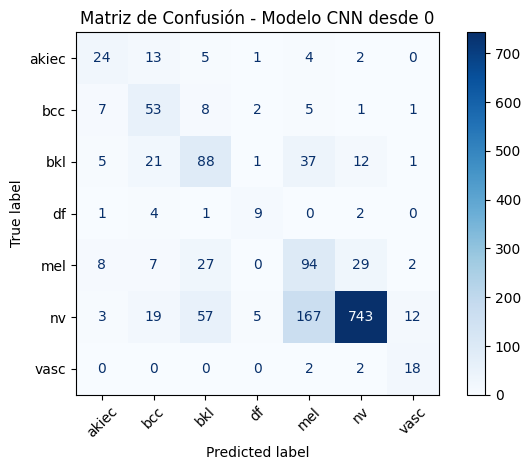

0.6846307385229541

In [99]:
y_pred_probs = model_img.predict(X_img_test)
evaluate_model(y_test, y_pred_probs, le_dx, model_name="Modelo CNN desde 0")

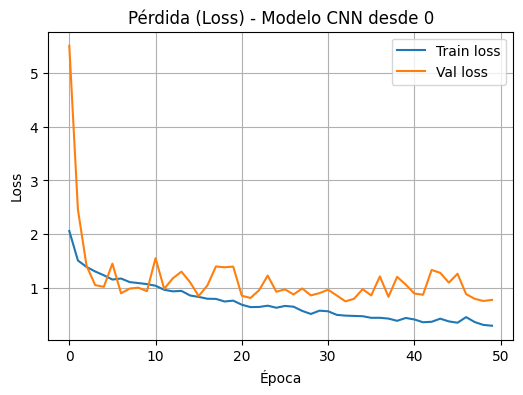

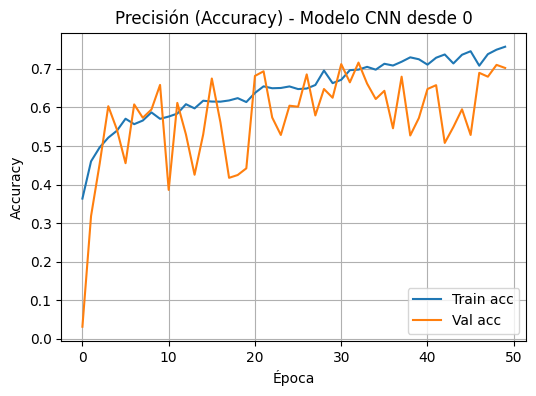

In [100]:
plot_training_curves(history_img, model_name="Modelo CNN desde 0")

📄 Metadata asociada:
lesion_id        HAM_0005988
image_id        ISIC_0025646
dx                        nv
dx_type            follow_up
age                     35.0
sex                   female
localization           trunk
Name: 5512, dtype: object

📐 Shape original de la imagen: (28, 28, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


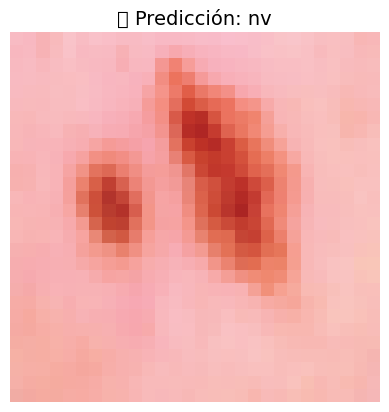

'nv'

In [101]:
predict_and_show_image(
    image_id=5512,
    model=model_img,
    label_encoder=le_dx,
    metadata=metadata,
    image_array=images,
    img_size=28,
)

# 🌐 9. Modelo con MobileNetV2 (Transfer Learning)

In [56]:
# 🔢 Tamaño objetivo compatible con MobileNetV2
IMG_SIZE = 96

# 🔄 Redimensionar imágenes de entrenamiento, validación y test
X_img_train_resized = tf.image.resize(X_img_train, (IMG_SIZE, IMG_SIZE))
X_img_val_resized = tf.image.resize(X_img_val, (IMG_SIZE, IMG_SIZE))
X_img_test_resized = tf.image.resize(X_img_test, (IMG_SIZE, IMG_SIZE))

In [58]:
# 🧪 Definir espacio de búsqueda para Hyperopt
search_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-3)),
    'dropout': hp.uniform('dropout', 0.3, 0.6),
    'dense_units': hp.choice('dense_units', [64, 128, 256]),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

# 🏷️ Número de clases (etiquetas one-hot)
num_classes = y_train.shape[1]

In [61]:
# 🎯 Función objetivo que entrena y devuelve la pérdida de validación negativa
def objective(params):
    # 🔍 Modelo base preentrenado
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False

    # 🔧 Definir arquitectura del modelo final
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(params["dropout"])(x)
    x = Dense(params["dense_units"], activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)

    # ⚙️ Compilar
    model.compile(
        optimizer=Adam(learning_rate=params["learning_rate"]),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # 🛑 Early stopping
    early_stop = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    # 🚀 Entrenamiento
    history = model.fit(
        X_img_train_resized,
        y_train,
        validation_data=(X_img_val_resized, y_val),
        epochs=15,
        batch_size=params["batch_size"],
        callbacks=[early_stop],
        verbose=0,
    )

    # 🔙 Retornar la pérdida negativa de validación
    val_acc = history.history["val_accuracy"][-1]
    return {"loss": -val_acc, "status": STATUS_OK}

In [62]:
# 🧪 Ejecutar la optimización bayesiana
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

print("\n✅ Mejor combinación de hiperparámetros encontrada:")
print(best_params)

100%|██████████| 20/20 [1:53:09<00:00, 339.47s/trial, best loss: -0.7370173335075378]

✅ Mejor combinación de hiperparámetros encontrada:
{'batch_size': np.int64(0), 'dense_units': np.int64(0), 'dropout': np.float64(0.33276830998478707), 'learning_rate': np.float64(0.00015255053372572848)}


In [64]:
best_dropout = best_params["dropout"]
best_units = [64, 128, 256][best_params["dense_units"]]
best_batch_size = [16, 32, 64][best_params["batch_size"]]
best_lr = best_params["learning_rate"]

print(f"dropout: {best_dropout:.2f}")
print(f"dense_units: {best_units}")
print(f"batch_size: {best_batch_size}")
print(f"learning_rate: {best_lr:.6f}")

dropout: 0.33
dense_units: 64
batch_size: 16
learning_rate: 0.000153


In [66]:
# 🔍 Cargar modelo base MobileNetV2 (sin capas superiores)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet"
)
base_model.trainable = False  # 🔒 Congelar pesos preentrenados

# 🧠 Añadir capas personalizadas encima del modelo base
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(best_dropout)(x)  # Regularización
x = Dense(best_units, activation="relu")(x)  # Capa totalmente conectada
outputs = Dense(y_train.shape[1], activation="softmax")(x)

# 🧩 Construcción del modelo final
model_mobile = Model(inputs, outputs)

# ⚙️ Compilar modelo con optimizador Adam
model_mobile.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [67]:
model_mobile.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,423 (8.93 MB)

 Trainable params: 82,439 (322.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [72]:
# 🔄 Data augmentation para imágenes de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

# 🛑 Parada temprana si la validación no mejora
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [89]:
# 🚀 Entrenar el modelo con data augmentation y class weights
history_mobile = model_mobile.fit(
    # datagen.flow(X_img_train_resized, y_train, batch_size=best_batch_size),  # flujo con augmentación
    X_img_train_resized,  # imágenes de entrenamiento redimensionadas
    y_train,  # etiquetas de entrenamiento
    validation_data=(X_img_val_resized, y_val),  # validación sin augmentación
    epochs=20,
    batch_size=best_batch_size,  # tamaño de lote
    # callbacks=[early_stop],
    class_weight=class_weights_dict,
)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.5710 - loss: 1.0281 - val_accuracy: 0.6145 - val_loss: 1.0309
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.5852 - loss: 1.0584 - val_accuracy: 0.6079 - val_loss: 1.0222
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.6000 - loss: 0.9407 - val_accuracy: 0.5879 - val_loss: 1.0579
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.5810 - loss: 0.9774 - val_accuracy: 0.6505 - val_loss: 0.9729
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5963 - loss: 0.9746 - val_accuracy: 0.6212 - val_loss: 1.0269
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.5809 - loss: 1.0062 - val_accuracy: 0.5539 - val_loss: 1.1786
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.5880 - loss: 1.0061 - val_accuracy: 0.6132 - val_loss: 1.0183
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.6169 - loss: 0.9676 - 

# 📈 10. Evaluación del modelo con MobileNetV2

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step

✅ Precisión total de Modelo con MobileNetV2: 0.5948

📊 Classification Report (Modelo con MobileNetV2):
              precision    recall  f1-score   support

       akiec       0.29      0.57      0.38        49
         bcc       0.34      0.36      0.35        77
         bkl       0.32      0.42      0.36       165
          df       0.14      0.76      0.23        17
         mel       0.29      0.46      0.36       167
          nv       0.93      0.66      0.77      1006
        vasc       0.48      0.68      0.57        22

    accuracy                           0.59      1503
   macro avg       0.40      0.56      0.43      1503
weighted avg       0.72      0.59      0.64      1503



<Figure size 800x600 with 0 Axes>

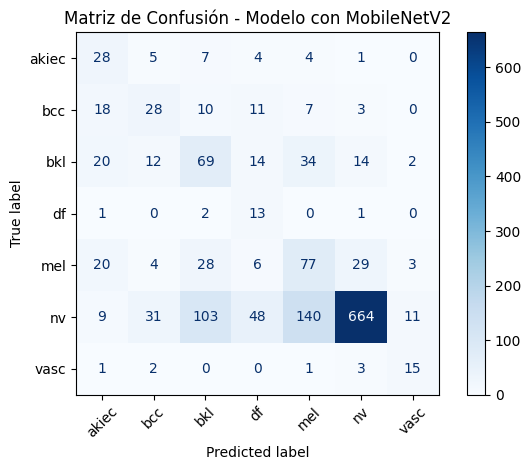

0.5948103792415169

In [90]:
y_pred_probs = model_mobile.predict(X_img_test_resized)
evaluate_model(y_test, y_pred_probs, le_dx, model_name="Modelo con MobileNetV2")

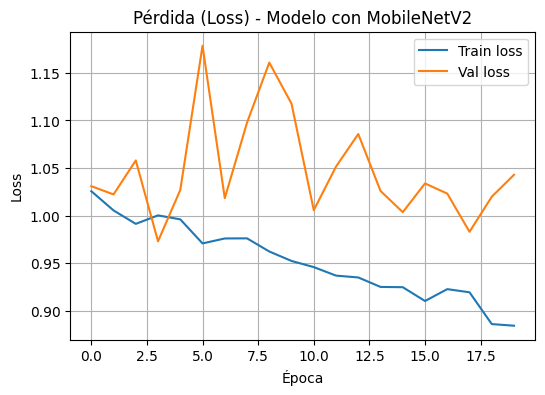

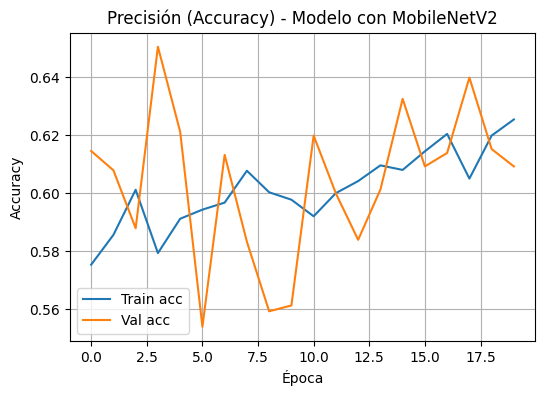

In [91]:
plot_training_curves(history_mobile, model_name="Modelo con MobileNetV2")

📄 Metadata asociada:
lesion_id        HAM_0003850
image_id        ISIC_0027237
dx                        nv
dx_type                histo
age                     50.0
sex                     male
localization             ear
Name: 8524, dtype: object

📐 Shape original de la imagen: (28, 28, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


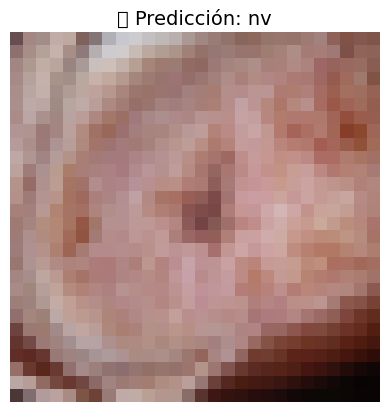

'nv'

In [92]:
predict_and_show_image(
    image_id=8524,
    model=model_mobile,
    label_encoder=le_dx,
    metadata=metadata,
    image_array=images,
    img_size=28,
)

# 🤝 11. Modelo combinado - Late Fusion (Hito 3)

In [102]:
print("X_img_train_resized:", X_img_train_resized.shape)
print("X_tab_train:", X_train.shape)
print("y_train:", y_train.shape)

X_img_train_resized: (7010, 96, 96, 3)
X_tab_train: (7010, 3)
y_train: (7010, 7)


In [ ]:
# 🖼️ Entrada de imágenes (CNN)
input_img = Input(shape=(28, 28, 3), name="image_input")

# 🔷 Bloque convolucional 1
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 🔷 Bloque convolucional 2
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 🔷 Bloque convolucional 3
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 🔻 Paso a capa densa
x = Flatten()(x)
x = Dropout(0.4)(x)  # Regularización antes de capa densa
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

# 📋 Entrada de datos tabulares (MLP)
input_tab = Input(shape=(X_train.shape[1],), name="tabular_input")
y = Dense(64, activation="relu")(input_tab)
y = Dropout(0.3)(y)
y = Dense(32, activation="relu")(y)

# 🔗 Fusión tardía (Late Fusion)
combined = Concatenate()([x, y])
z = Dense(128, activation="relu")(combined)
z = Dropout(0.3)(z)
output = Dense(y_cat.shape[1], activation="softmax", name="output")(z)

# 🧩 Modelo final
model_combined = Model(inputs=[input_img, input_tab], outputs=output)

# ⚙️ Compilar el modelo
model_combined.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)

In [116]:
model_combined.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 28,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 14, 14,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 3, 3, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1152)      │          0 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 1152)      │          0 │ flatten_6[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 64)        │        256 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_119 (Dense)   │ (None, 128)       │    147,584 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 64)        │          0 │ dense_120[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 128)       │          0 │ dense_119[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_121 (Dense)   │ (None, 32)        │      2,080 │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 265,575 (1.01 MB)

 Trainable params: 265,127 (1.01 MB)

 Non-trainable params: 448 (1.75 KB)

In [118]:
# 🚀 Entrenar modelo combinado con imagen + datos tabulares (Late Fusion)
history_combined = model_combined.fit(
    [X_img_train, X_train],  # Entradas: imagen + datos tabulares
    y_train,  # Etiquetas
    validation_data=([X_img_val, X_val], y_val),  # Validación conjunta
    epochs=30,  # Número de épocas
    batch_size=32,  # Tamaño del batch
    verbose=1,  # Mostrar progreso por época
    class_weight=class_weights_dict,  # Pesos de clase para desbalanceo
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5943 - loss: 1.5015 - val_accuracy: 0.5779 - val_loss: 1.0400
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5596 - loss: 1.3843 - val_accuracy: 0.6531 - val_loss: 0.8639
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6032 - loss: 1.1473 - val_accuracy: 0.6039 - val_loss: 1.1428
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5932 - loss: 1.1737 - val_accuracy: 0.6218 - val_loss: 1.0257
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5705 - loss: 1.1230 - val_accuracy: 0.5519 - val_loss: 1.1199
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5965 - loss: 1.0488 - val_accuracy: 0.2983 - val_loss: 1.4506
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5968 - loss: 0.9866 - val_accuracy: 0.3036 - val_loss: 1.6463
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6293 - loss: 1.0155 - val_accu

# 📈 12. Evaluación del modelo Late Fusion

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

✅ Precisión total de Modelo Late Fusion: 0.6367

📊 Classification Report (Modelo Late Fusion):
              precision    recall  f1-score   support

       akiec       0.52      0.35      0.41        49
         bcc       0.51      0.56      0.53        77
         bkl       0.37      0.60      0.46       165
          df       0.42      0.59      0.49        17
         mel       0.31      0.72      0.43       167
          nv       0.97      0.65      0.78      1006
        vasc       0.58      0.68      0.62        22

    accuracy                           0.64      1503
   macro avg       0.52      0.59      0.53      1503
weighted avg       0.78      0.64      0.67      1503



<Figure size 800x600 with 0 Axes>

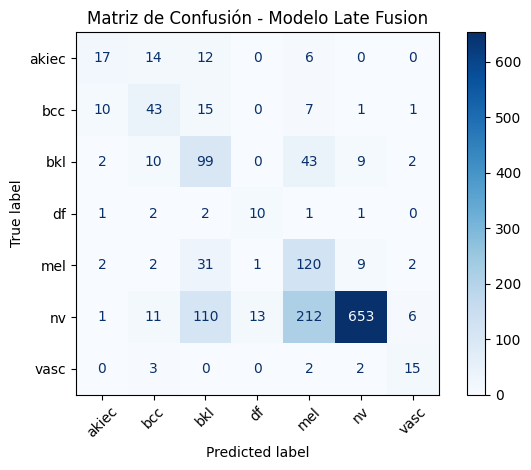

0.6367265469061876

In [119]:
y_pred_probs = model_combined.predict([X_img_test, X_test])
evaluate_model(y_test, y_pred_probs, le_dx, model_name="Modelo Late Fusion")

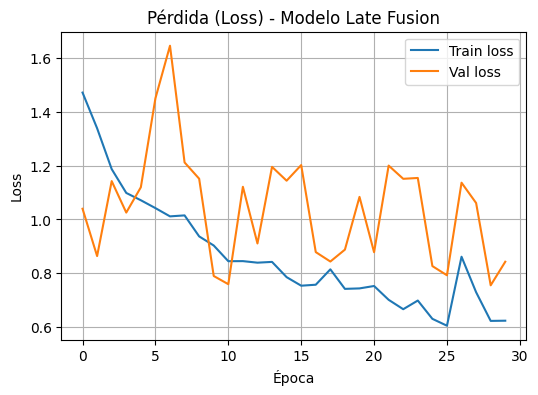

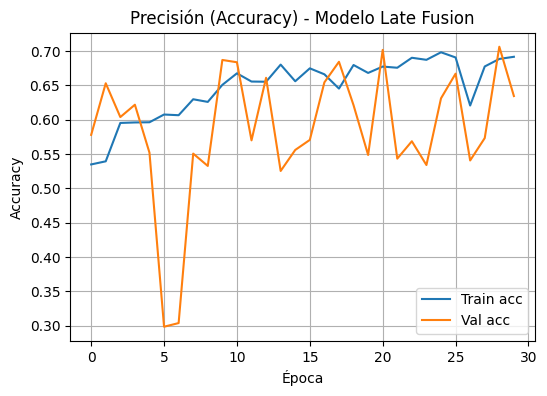

In [120]:
plot_training_curves(history_combined, model_name="Modelo Late Fusion")

📄 Metadata del caso:
lesion_id           HAM_0004897
image_id           ISIC_0026293
dx                           nv
dx_type                   histo
age                        30.0
sex                      female
localization    lower extremity
Name: 8654, dtype: object
📐 Shape de la imagen original: (28, 28, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


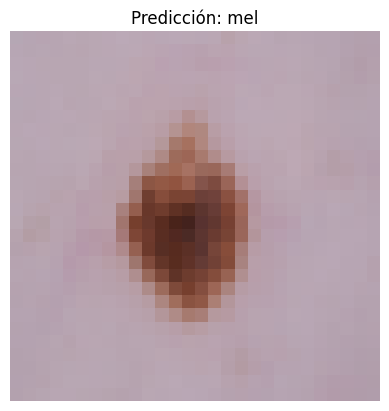

✅ Diagnóstico predicho: mel


'mel'

In [124]:
new_patient = {"age": 70, "sex": "male", "localization": "ear"}

predict_combined_case(
    image_id=8654,
    metadata=metadata,
    images_array=images,
    patient_info=new_patient,
    model=model_combined,
    le_sex=le_sex,
    le_loc=le_loc,
    le_dx=le_dx,
    scaler=scaler,
    img_size=28,
)

# 🤝 13. Modelo Early Fusion (Hito 4)

In [125]:
# 🔹 1. Entradas: imagen y datos tabulares
input_img = Input(shape=(28, 28, 3), name="image_input")
input_tab = Input(shape=(X_train.shape[1],), name="tabular_input")

# 🔹 2. Aplanar imagen (sin usar convoluciones)
flat_img = Flatten()(input_img)

# 🔹 3. Fusión temprana (early fusion): concatenar imagen + tabular
merged = Concatenate()([flat_img, input_tab])

# 🔹 4. Capas densas tras la fusión
x = Dense(256, activation="relu")(merged)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output = Dense(y_cat.shape[1], activation="softmax", name="output")(x)

# 🔹 5. Modelo final
model_early = Model(inputs=[input_img, input_tab], outputs=output)

# ⚙️ Compilar
model_early.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [129]:
model_early.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 2352)      │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 2355)      │          0 │ flatten_7[0][0],  │
│ (Concatenate)       │                   │            │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_123 (Dense)   │ (None, 256)       │    603,136 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 256)       │          0 │ dense_123[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 128)       │     32,896 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 7)         │        903 │ dense_124[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,910,807 (7.29 MB)

 Trainable params: 636,935 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,273,872 (4.86 MB)

In [ ]:
# 🚀 Entrenamiento
history_early = model_early.fit(
    [X_img_train, X_train],  # Imagen y tabular
    y_train,
    validation_data=([X_img_val, X_val], y_val),
    epochs=30,
    batch_size=32,
    # callbacks=[early_stop],
    verbose=1,
    # class_weight=class_weights_dict,
)

Epoch 1/30


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [139]:
print("X_img_train:", X_img_train.shape)
print("X_train:", X_train.shape)

X_img_train: (7010, 28, 28, 3)
X_train: (7010, 3)


# 📈 14. Evaluación del modelo Early Fusion

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Precisión total de Modelo Early Fusion: 0.6640

📊 Classification Report (Modelo Early Fusion):
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.00      0.00      0.00        77
         bkl       0.14      0.01      0.01       165
          df       0.00      0.00      0.00        17
         mel       0.33      0.05      0.08       167
          nv       0.68      0.98      0.80      1006
        vasc       0.00      0.00      0.00        22

    accuracy                           0.66      1503
   macro avg       0.16      0.15      0.13      1503
weighted avg       0.51      0.66      0.55      1503



c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defi

<Figure size 800x600 with 0 Axes>

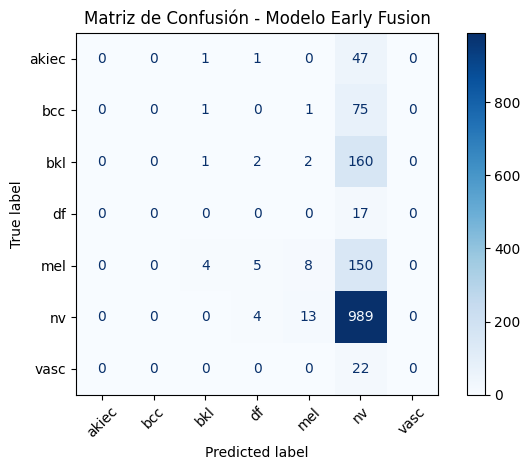

0.6640053226879574

In [148]:
y_pred_probs = model_early.predict([X_img_test, X_test])
evaluate_model(y_test, y_pred_probs, le_dx, model_name="Modelo Early Fusion")

In [149]:
plot_training_curves(history_early, model_name="Modelo Early Fusion")

NameError: name 'history_early' is not defined

In [ ]:
new_patient = {"age": 70, "sex": "male", "localization": "ear"}

predict_combined_case(
    image_id=976,
    metadata=metadata,
    images_array=images,
    patient_info=new_patient,
    model=model_early,
    le_sex=le_sex,
    le_loc=le_loc,
    le_dx=le_dx,
    scaler=scaler,
    img_size=28,
)